# Validate results of SuperLearner(R version)

This script can parse results of SuperLearner(R version) and calculate AUROC and AUPRC for mortality prediction tasks.

In [60]:
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
readRDS = robjects.r['readRDS']
df = readRDS('../../Data/admdata_17f/24hrs/non_series/folds/results.rds')
df = pandas2ri.ri2py(df)
df

R object with classes: ('list',) mapped to:
<ListVector - Python:0x7fdf7a370d48 / R:0x3337310>
[ListVec..., ListVec..., ListVec..., ListVec..., ListVec...]
R object with classes: ('list',) mapped to:
<ListVector - Python:0x7fdf7a370d48 / R:0x3337310>
[ListVec..., ListVec..., ListVec..., ListVec..., ListVec...]
R object with classes: ('list',) mapped to:
<ListVector - Python:0x7fdf7a370d48 / R:0x3337310>
[ListVec..., ListVec..., ListVec..., ListVec..., ListVec...]
R object with classes: ('list',) mapped to:
<ListVector - Python:0x7fdf7a370d48 / R:0x3337310>
[ListVec..., ListVec..., ListVec..., ListVec..., ListVec...]
R object with classes: ('list',) mapped to:
<ListVector - Python:0x7fdf7a370d48 / R:0x3337310>
[ListVec..., ListVec..., ListVec..., ListVec..., ListVec...]
R object with classes: ('list',) mapped to:
<ListVector - Python:0x7fdf7a370d48 / R:0x3337310>
[ListVec..., ListVec..., ListVec..., ListVec..., ListVec...]

## Validate base algorithms

Print the CV-risk(L2-loss) and standard error of each base algorithm.

In [59]:
from collections import OrderedDict

algonames = ["SL.glmnet","SL.glm","SL.stepAIC","SL.nnet","SL.polymars","SL.randomForest","SL.gam","SL.rpartPrune", "SL.bayesglm"]
cvrisks = {}
SLrisks = []
for dfone in df:
    libpredict = pandas2ri.ri2py(dfone[2])
    ylabel = pandas2ri.ri2py(dfone[0]).astype(np.float64)
    for an in range(libpredict.shape[1]):
        ypred = libpredict[:,an].flatten()
        ydiff = ypred - ylabel
        n2risk = np.dot(ydiff, ydiff) / ydiff.shape[0]
        try:
            cvrisks[algonames[an]].append(n2risk)
        except KeyError:
            cvrisks[algonames[an]] = [n2risk]
    slpred = pandas2ri.ri2py(dfone[1]).astype(np.float64).flatten()
    sldiff = slpred - ylabel
    slrisk = np.dot(sldiff, sldiff) / sldiff.shape[0]
    SLrisks.append(slrisk)
            
for key, value in cvrisks.items():
    print(key, '\t', np.mean(value), '\t', np.std(value), '\t', np.min(value), '\t', np.max(value))
print('SL', '\t', np.mean(SLrisks), '\t', np.std(SLrisks), '\t', np.min(SLrisks), '\t', np.max(SLrisks))
    
for an in range(len(algonames)):
    predicts = np.concatenate([pandas2ri.ri2py(dfone[2])[:,an] for dfone in df])
    print(algonames[an], '\t', np.max(predicts), '\t', np.min(predicts))

SL.glmnet 	 0.0789181979508 	 0.00058032165225 	 0.0780703275993 	 0.079584740411
SL.glm 	 0.0789085017996 	 0.000572876436936 	 0.0780530370011 	 0.0795823207954
SL.stepAIC 	 0.0791729602856 	 0.000624771427007 	 0.0782237105261 	 0.0798916121732
SL.nnet 	 0.104890978324 	 5.81086532791e-05 	 0.104812684159 	 0.104938271605
SL.polymars 	 0.0734823284579 	 0.000815350011958 	 0.0727448182204 	 0.0750185779391
SL.randomForest 	 0.0712115299574 	 0.000535206849987 	 0.070345869492 	 0.0718999433142
SL.gam 	 0.0753410601999 	 0.000592153601054 	 0.0746027013681 	 0.075920569666
SL.rpartPrune 	 0.0841251451507 	 0.00117644820509 	 0.0830697712855 	 0.0863265457073
SL.bayesglm 	 0.0789079489949 	 0.000571725767163 	 0.078056034438 	 0.0795820001946
SL 	 0.0707180066549 	 0.000412352902597 	 0.0699364069682 	 0.071162789567
SL.glmnet 	 0.997512362986 	 6.75472029772e-24
SL.glm 	 0.997646559524 	 2.22044604925e-16
SL.stepAIC 	 0.999057746987 	 2.22044604925e-16
SL.nnet 	 0.0 	 0.0
SL.polymars

[ 0.00113743  0.00112284  0.00122455  0.00159809  0.00104901  0.00116062
  0.00230584  0.00112058  0.00104901  0.00080821]


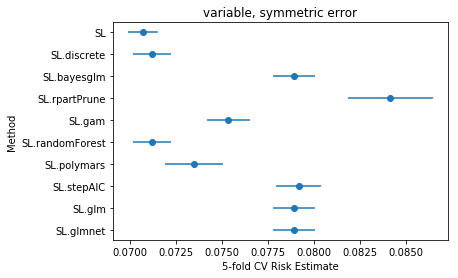

In [56]:
algoname_labels = []
means = []
stds = []
for key, value in cvrisks.items():
    if key == 'SL.nnet':
        continue
    algoname_labels.append(key)
    means.append(np.mean(value))
    stds.append(np.std(value))
    
algoname_labels.append('SL.discrete')
argmin = np.argmin(means)
means.append(means[argmin])
stds.append(stds[argmin])

algoname_labels.append('SL')
means.append(np.mean(SLrisks))
stds.append(np.std(SLrisks))

error = 1.96 * np.array(stds)
print(error)
fig, ax0 = plt.subplots()
ax0.errorbar(means, np.arange(len(means)), xerr=error, fmt='o')
ax0.set_yticks(np.arange(len(algoname_labels)))
ax0.set_yticklabels(algoname_labels)
ax0.set_xlabel('5-fold CV Risk Estimate')
ax0.set_ylabel('Method')
ax0.set_title('variable, symmetric error')

plt.show()

## Calculate metrics

Calculate AUPRC (or AUROC) from saved results.

In [79]:
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import roc_auc_score, average_precision_score

readRDS = robjects.r['readRDS']
df = readRDS('../../Data/admdata_99p/24hrs_raw/non_series/results.rds')
df = pandas2ri.ri2py(df)

ress = []

for dfone in df:
    ypredict = pandas2ri.ri2py(dfone[1]).astype(np.float64)
    ylabel = pandas2ri.ri2py(dfone[0]).astype(np.float64)
    if np.all(~np.isnan(ypredict)):
        ress.append(average_precision_score(ylabel, ypredict))
print(np.mean(ress), np.std(ress))

0.473168799978 0.00852069522563
